In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from prophet import Prophet
from scipy import stats
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error


/Users/timhong/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Adding Multiple Regressors

In [ ]:
data = pd.read_excel("owid-covid-data.xlsx")

In [8]:
country_list = [
    'Belgium', 'Denmark', 'Finland', 'Ireland', 'Italy',
    'Lithuania', 'Norway', 'Poland', 'Switzerland', 'United Kingdom'
]

selected_data = data[data['location'].isin(country_list)]
selected_data.head()



,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
28497,BEL,Europe,Belgium,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28498,BEL,Europe,Belgium,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28499,BEL,Europe,Belgium,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,-151.3,-6.34,-6.34,-13.086293
28500,BEL,Europe,Belgium,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28501,BEL,Europe,Belgium,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN


In [6]:
data_clean = selected_data[["location", "date", "new_cases"]]
data_clean.head()

,location,date,new_cases
28497,Belgium,2020-01-03,0.0
28498,Belgium,2020-01-04,0.0
28499,Belgium,2020-01-05,0.0
28500,Belgium,2020-01-06,0.0
28501,Belgium,2020-01-07,0.0


## Data Prep

### Removing irrelevant dates


Dates to remove specified in ARIMA file.

In [9]:
# Subset the dataset
data_clean = selected_data[(selected_data['date'] >= '2020-03-01') & (selected_data['date'] <= '2023-01-15')]

In [10]:
# check missingness
missing_values_count = data_clean['new_cases'].isnull().sum()
print(missing_values_count)

0


### Removing variables

#### Dropping more than 30% missingness

In [11]:

# create a table that shows the number of features with more than 30% missing values for each country
def missing_features_by_country(df):

    missingness = df.groupby('location').apply(lambda group: group.isna().mean() * 100)
    
    # Count the number of features with more than 30% missing values for each country
    features_missing_40 = (missingness > 30).sum(axis=1)
    
    # Create a summary DataFrame
    summary = pd.DataFrame({
        'Country': features_missing_40.index,
        'Features with >40% Missingness': features_missing_40.values
    })
    
    return summary.sort_values(by='Features with >40% Missingness', ascending=True)

# Calculate and display the results
missing_features_summary = missing_features_by_country(data_clean)
print(missing_features_summary)

          Country  Features with >40% Missingness
4           Italy                               7
0         Belgium                               9
8     Switzerland                              13
1         Denmark                              16
3         Ireland                              16
2         Finland                              19
9  United Kingdom                              20
5       Lithuania                              22
6          Norway                              26
7          Poland                              27


In [12]:
#data missingness
missing_data = data_clean.isnull().sum()
threshold = 0.3 * len(data_clean)
missing_data = missing_data[missing_data < threshold]
missing_data

iso_code                              0
continent                             0
location                              0
date                                  0
total_cases                          25
new_cases                             0
new_cases_smoothed                    0
total_deaths                         81
new_deaths                            0
new_deaths_smoothed                   0
total_cases_per_million              25
new_cases_per_million                 0
new_cases_smoothed_per_million        0
total_deaths_per_million             81
new_deaths_per_million                0
new_deaths_smoothed_per_million       0
reproduction_rate                   223
hosp_patients                      2499
hosp_patients_per_million          2499
total_tests                        3023
new_tests                          3146
total_tests_per_thousand           3023
new_tests_per_thousand             3146
new_tests_smoothed                 2365
new_tests_smoothed_per_thousand    2365


In [13]:
# drop features with >30% missingness
threshold = 0.7 * len(selected_data)

data_clean = data_clean.dropna(thresh=threshold, axis=1)
data_clean.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population'],
      dtype='object')

#### Removing constants

In [14]:

# Assuming 'df' is your DataFrame
df_grouped = data_clean.groupby('location')

threshold = 0.95

# For each location after grouping
constant_columns_by_location = df_grouped.apply(lambda group: group.columns[group.apply(lambda col: col.value_counts(normalize=True).max() >= threshold)])

constant_columns_df = constant_columns_by_location.reset_index(name='cons_variables')


print(constant_columns_df['cons_variables'].iloc[0])

Index(['iso_code', 'continent', 'location', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population'],
      dtype='object')


Constant Variables:

['iso_code', 'continent', 'location', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population']

Keeping location though!

In [15]:
variables_to_remove = ['iso_code', 'continent', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population']

data_clean_subset = data_clean.drop(columns=variables_to_remove)
data_clean_subset.columns



Index(['location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed',
       'total_deaths', 'new_deaths', 'new_deaths_smoothed',
       'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million',
       'reproduction_rate', 'stringency_index'],
      dtype='object')

Still need to remove all the totals and smoothers: 'total_cases', 'total_deaths', 'new_cases_smoothed', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million'

In [16]:
remove = ['total_cases', 'total_deaths', 'new_cases_smoothed', 'new_deaths_smoothed', 
          'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 
          'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million']

data_clean_subset = data_clean_subset.drop(columns=remove)
data_clean_subset.columns


Index(['location', 'date', 'new_cases', 'new_deaths', 'reproduction_rate',
       'stringency_index'],
      dtype='object')

In [17]:
data_clean_subset.head()

,location,date,new_cases,new_deaths,reproduction_rate,stringency_index
28555,Belgium,2020-03-01,0.0,0.0,NaN,11.11
28556,Belgium,2020-03-02,0.0,0.0,NaN,11.11
28557,Belgium,2020-03-03,18.0,0.0,NaN,11.11
28558,Belgium,2020-03-04,19.0,0.0,NaN,13.89
28559,Belgium,2020-03-05,34.0,0.0,NaN,13.89


#### Testing for Multicollinearity

In [18]:
## date as index
# Convert 'ds' to datetime if it's not already

data_clean_subset['date'] = pd.to_datetime(data_clean['date'])

data_clean_subset.set_index('date', inplace=True)

In [19]:
data_clean_subset.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index
date,,,,,
2020-03-01,Belgium,0.0,0.0,NaN,11.11
2020-03-02,Belgium,0.0,0.0,NaN,11.11
2020-03-03,Belgium,18.0,0.0,NaN,11.11
2020-03-04,Belgium,19.0,0.0,NaN,13.89
2020-03-05,Belgium,34.0,0.0,NaN,13.89


<Axes: >

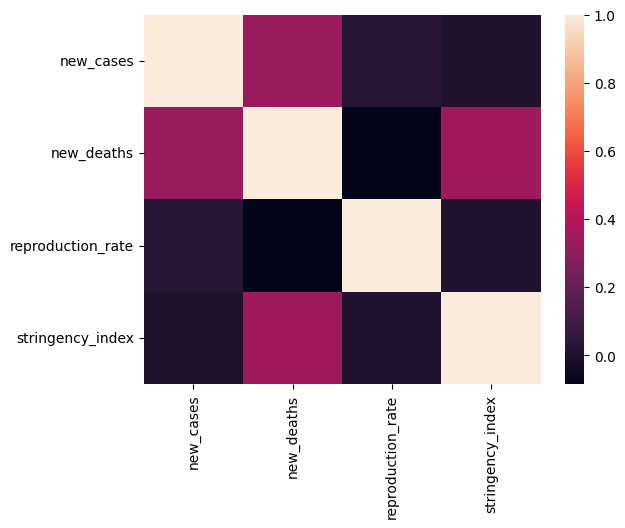

In [20]:
for_corr = data_clean_subset.copy().drop(columns=['location'])
correlation = for_corr.corr( method='pearson' )
sns.heatmap( correlation )

Pretty good on collinearity, can move forward with these variables.

### Outliers

Prophet is robust to outliers, so we won't remove them!

In [21]:
cleaned_df = data_clean_subset.copy()

cleaned_df.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index
date,,,,,
2020-03-01,Belgium,0.0,0.0,NaN,11.11
2020-03-02,Belgium,0.0,0.0,NaN,11.11
2020-03-03,Belgium,18.0,0.0,NaN,11.11
2020-03-04,Belgium,19.0,0.0,NaN,13.89
2020-03-05,Belgium,34.0,0.0,NaN,13.89


I want to use forward fill to impute new_cases and new_deaths, and impute the other two with the mean

In [22]:
# Forward fill new_cases and new_deaths
cleaned_df['new_cases'].fillna(method='ffill', inplace=True)
cleaned_df['new_deaths'].fillna(method='ffill', inplace=True)

# Impute reproduction_rate and stringency_index with mean
mean_reproduction_rate = cleaned_df['reproduction_rate'].mean()
mean_stringency_index = cleaned_df['stringency_index'].mean()

cleaned_df['reproduction_rate'].fillna(mean_reproduction_rate, inplace=True)
cleaned_df['stringency_index'].fillna(mean_stringency_index, inplace=True)

/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/4074590272.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_df['new_cases'].fillna(method='ffill', inplace=True)
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/4074590272.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_df['new_deaths'].fillna(method='ffill', inplace=True)


In [23]:
cleaned_df.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index
date,,,,,
2020-03-01,Belgium,0.0,0.0,1.058986,11.11
2020-03-02,Belgium,0.0,0.0,1.058986,11.11
2020-03-03,Belgium,18.0,0.0,1.058986,11.11
2020-03-04,Belgium,19.0,0.0,1.058986,13.89
2020-03-05,Belgium,34.0,0.0,1.058986,13.89


In [24]:
# remove location and store it separately
location_names = cleaned_df['location'].unique()

prophet_df = cleaned_df.drop(columns= 'location')
prophet_df.shape



(10510, 4)

Split: 

14/1051 = 0.01332065

1 - 0.01332065 = 0.98667935

## Feature Engineering

### Creating Lag Features

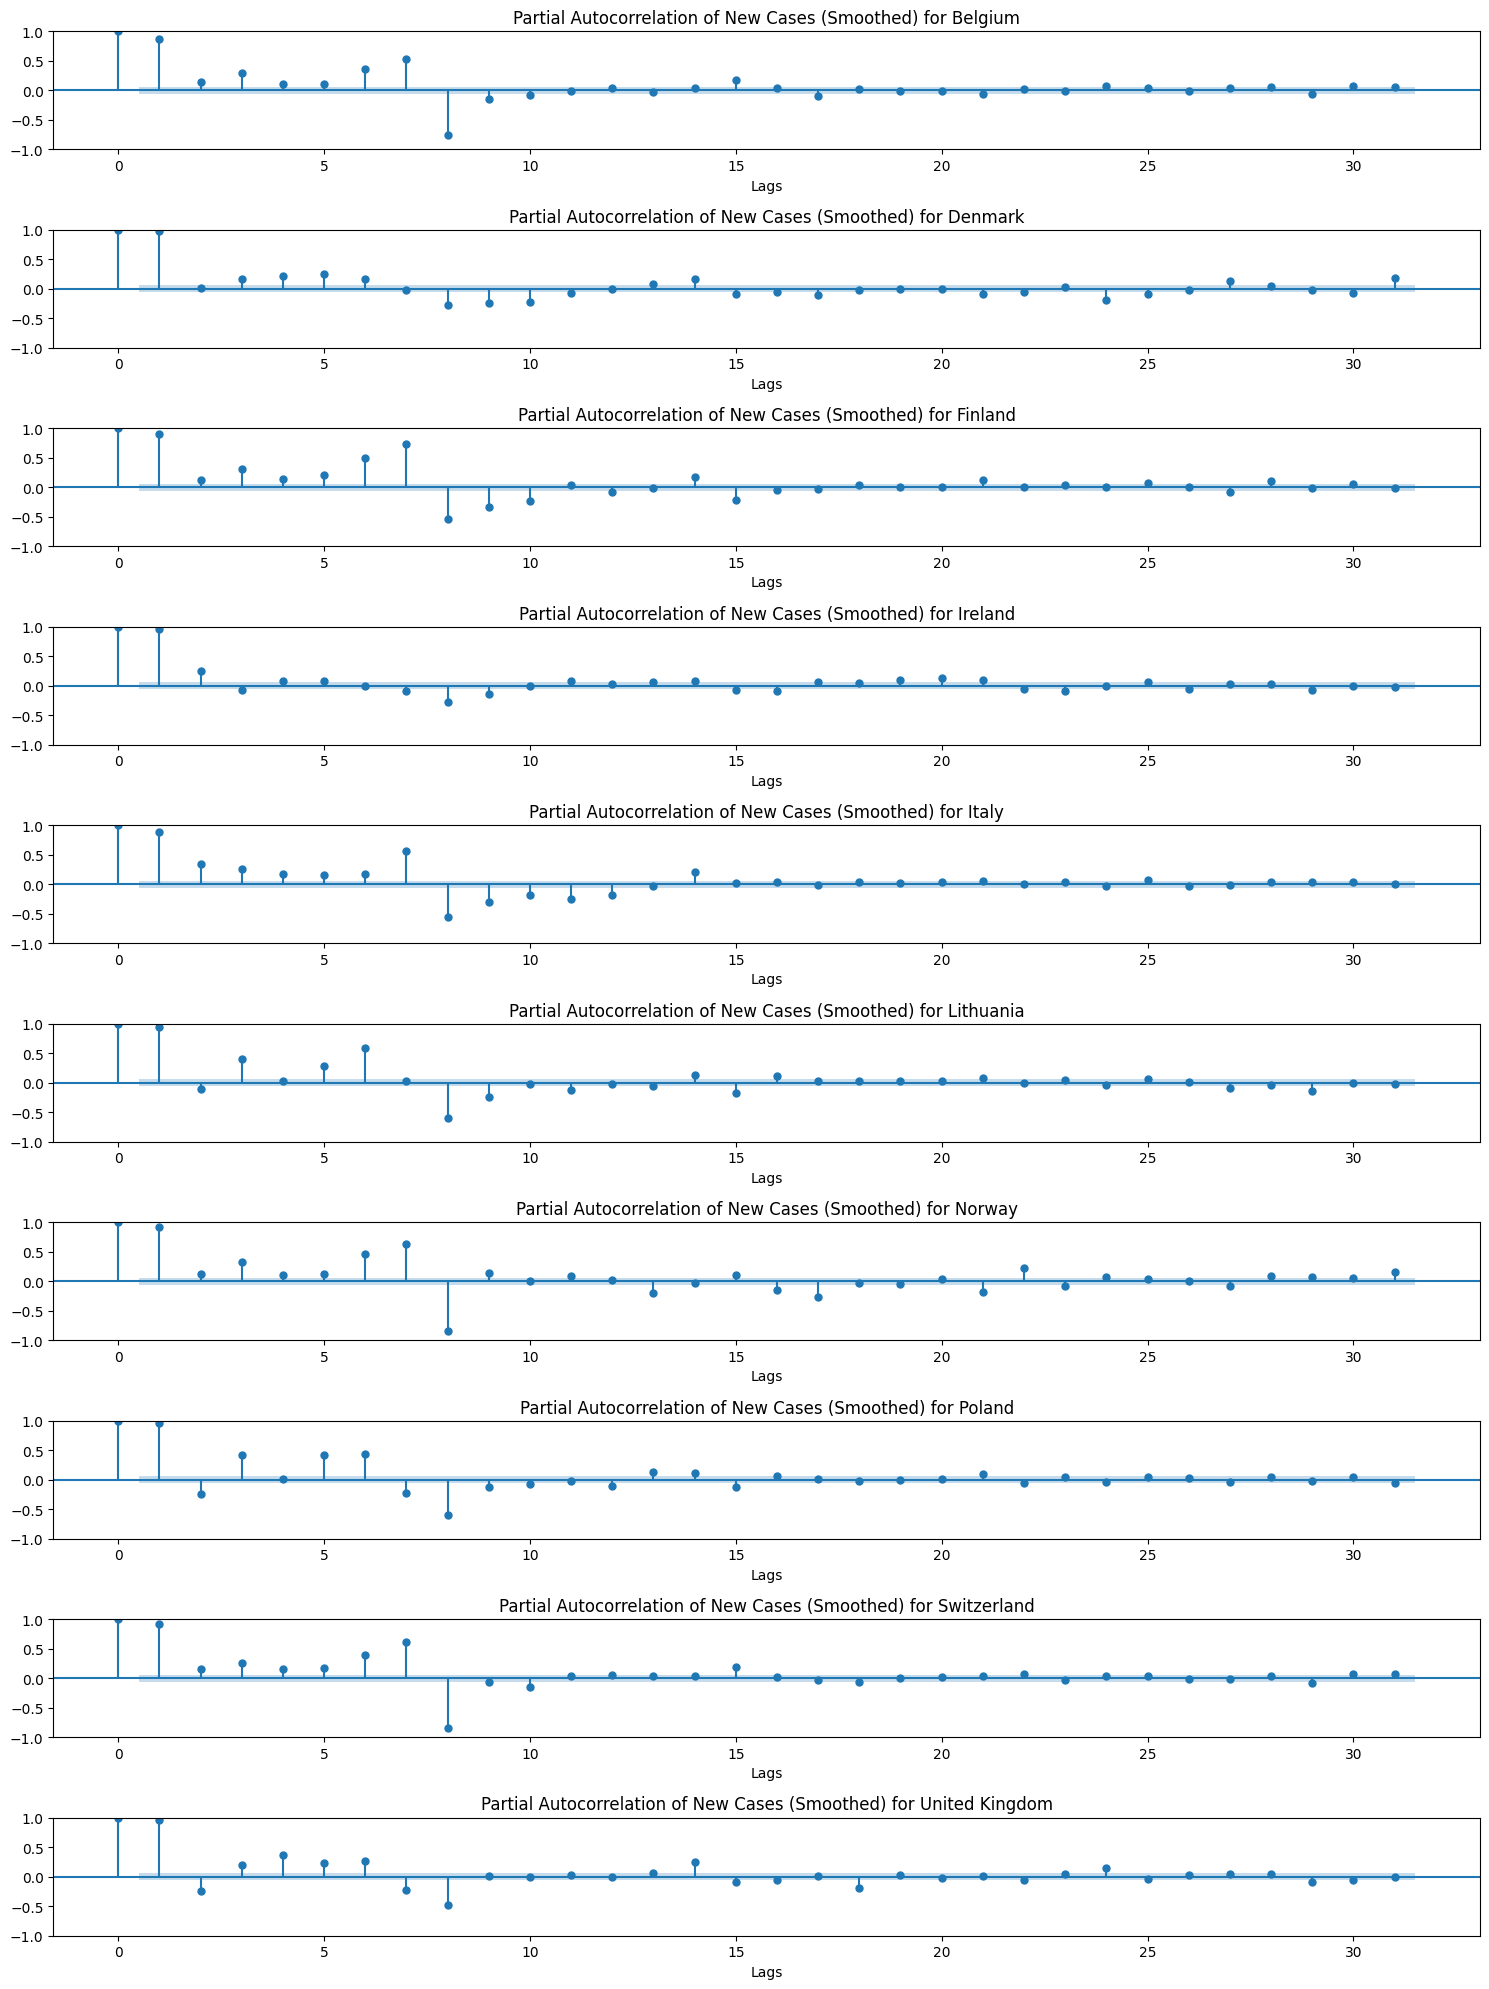

In [25]:
### Examining PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

countries = cleaned_df['location'].unique()

plt.figure(figsize=(15, 20))

for i, country in enumerate(countries, 1):
    plt.subplot(len(countries), 1, i)
    country_data = cleaned_df[cleaned_df['location'] == country]['new_cases']
    plot_pacf(country_data.dropna(), alpha=0.05, ax=plt.gca())
    plt.title(f'Partial Autocorrelation of New Cases (Smoothed) for {country}')
    plt.xlabel('Lags')

plt.tight_layout()
plt.show()

Spikes at lags 1 and 8, adding lags at 1 and 8.

In [26]:
data_clean_lag = cleaned_df.copy()

for lag in [1, 8]:
    data_clean_lag[f'new_cases_lag{lag}'] = data_clean_lag['new_cases'].shift(lag)

data_clean_lag.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8
date,,,,,,,
2020-03-01,Belgium,0.0,0.0,1.058986,11.11,NaN,NaN
2020-03-02,Belgium,0.0,0.0,1.058986,11.11,0.0,NaN
2020-03-03,Belgium,18.0,0.0,1.058986,11.11,0.0,NaN
2020-03-04,Belgium,19.0,0.0,1.058986,13.89,18.0,NaN
2020-03-05,Belgium,34.0,0.0,1.058986,13.89,19.0,NaN


### Creating Rolling Mean Features

In [27]:
data_clean_roll_mean = data_clean_lag.copy()
# rolling window 7-day and 14-day for new_cases
for window in [7, 14]:
    data_clean_roll_mean[f'new_cases_roll_mean{window}'] = data_clean_roll_mean['new_cases'].rolling(window=window).mean()
    data_clean_roll_mean[f'new_cases_roll_std{window}'] = data_clean_roll_mean['new_cases'].rolling(window=window).std()

data_clean_roll_mean.head(10)

,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14
date,,,,,,,,,,,
2020-03-01,Belgium,0.0,0.0,1.058986,11.11,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,Belgium,0.0,0.0,1.058986,11.11,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-03,Belgium,18.0,0.0,1.058986,11.11,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-04,Belgium,19.0,0.0,1.058986,13.89,18.0,NaN,NaN,NaN,NaN,NaN
2020-03-05,Belgium,34.0,0.0,1.058986,13.89,19.0,NaN,NaN,NaN,NaN,NaN
2020-03-06,Belgium,53.0,0.0,1.058986,13.89,34.0,NaN,NaN,NaN,NaN,NaN
2020-03-07,Belgium,81.0,0.0,2.430000,13.89,53.0,NaN,29.285714,29.460223,NaN,NaN
2020-03-08,Belgium,110.0,0.0,2.410000,13.89,81.0,NaN,45.000000,39.021362,NaN,NaN
2020-03-09,Belgium,27.0,1.0,2.410000,13.89,110.0,0.0,48.857143,34.954392,NaN,NaN


In [65]:
cleaned_df = data_clean_roll_mean.copy()
cleaned_df.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14
date,,,,,,,,,,,
2020-03-01,Belgium,0.0,0.0,1.058986,11.11,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,Belgium,0.0,0.0,1.058986,11.11,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-03,Belgium,18.0,0.0,1.058986,11.11,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-04,Belgium,19.0,0.0,1.058986,13.89,18.0,NaN,NaN,NaN,NaN,NaN
2020-03-05,Belgium,34.0,0.0,1.058986,13.89,19.0,NaN,NaN,NaN,NaN,NaN


### Grid Search to Tune Hyperparameters

In [ ]:
# import pandas as pd
# from prophet import Prophet
# from prophet.diagnostics import cross_validation, performance_metrics
# from prophet.plot import plot_cross_validation_metric
# from sklearn.model_selection import ParameterGrid
# from tqdm import tqdm

# # Assuming you have a DataFrame data_prepped with a 'new_cases' column, 'date' as the index, and 'location' column
# # Make sure 'date' is set as the index

# # Define features and target variable
# X = cleaned_df.drop('new_cases', axis=1)
# y = cleaned_df['new_cases']

# # Initialize hyperparameter grid
# param_grid = {
#     'changepoint_prior_scale': [0.001, 0.01, 0.1],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0],
#     'holidays_prior_scale': [0.01, 0.1, 1.0],
#     'seasonality_mode': ['additive', 'multiplicative']
# }

# # Create an empty DataFrame to store results
# initial_results_df = pd.DataFrame(columns=['location', 'initial_rmse'])

# # Get unique locations
# locations = X['location'].unique()

# # Iterate over locations
# for location in tqdm(locations, desc="Grid Search Progress"):
#     print(f"\nPerforming grid search for location: {location}")

#     # Filter data for the current location
#     df_location = cleaned_df[cleaned_df['location'] == location].reset_index()

#     # Prepare data for Prophet
#     df_prophet = df_location[['date', 'new_cases']]
#     df_prophet = df_prophet.rename(columns={'date': 'ds', 'new_cases': 'y'})

#     # Split the data into training and testing sets
#     train_size = int(len(df_prophet) * 0.98667935)
#     train_data, test_data = df_prophet.iloc[:train_size], df_prophet.iloc[train_size:]

#     # Initialize best hyperparameters and RMSE
#     best_params = None
#     best_rmse = float('inf')

#     # Iterate over hyperparameter combinations
#     for params in tqdm(list(ParameterGrid(param_grid)), desc="Hyperparameter Search Progress", leave=False):
#         # Initialize Prophet model
#         prophet_model = Prophet(
#             changepoint_prior_scale=params['changepoint_prior_scale'],
#             seasonality_prior_scale=params['seasonality_prior_scale'],
#             holidays_prior_scale=params['holidays_prior_scale'],
#             seasonality_mode=params['seasonality_mode']
#         )

#         # Fit the model
#         prophet_model.fit(train_data)

#         # Make predictions on the test set
#         future = prophet_model.make_future_dataframe(periods=len(test_data))
#         forecast = prophet_model.predict(future)

#         # Calculate RMSE
#         rmse = ((forecast.loc[train_size:, 'yhat'] - test_data['y'])**2).mean()**0.5

#         # Update best hyperparameters if RMSE improves
#         if rmse < best_rmse:
#             best_rmse = rmse
#             best_params = params

#     print(f"Best hyperparameters for {location}: {best_params}")
#     print(f"Best RMSE for {location}: {best_rmse}")

#     # Store results in the DataFrame
#     initial_results_df = pd.concat([initial_results_df, pd.DataFrame({'location': [location], 'initial_rmse': [best_rmse]})], ignore_index=True)

# # Print or save the results DataFrame as needed
# initial_results_df


Ran param grid search in prophet single, results are below:

In [31]:
## Storing params
belgium_params = {
    'changepoint_prior_scale': 0.1,
    'seasonality_mode': 'multiplicative',
    'seasonality_prior_scale': 0.01
}
denmark_params = {'changepoint_prior_scale': 0.1,
                  'seasonality_mode':'multiplicative', 
                  'seasonality_prior_scale': 0.01}

finland_params = {'changepoint_prior_scale': 0.1,
                  'seasonality_mode': 'multiplicative', 
                  'seasonality_prior_scale': 1.0}

ireland_params = {'changepoint_prior_scale': 0.1,
                  'seasonality_mode': 'multiplicative', 
                  'seasonality_prior_scale': 0.1}

italy_params = {'changepoint_prior_scale': 0.1,
                'seasonality_mode': 'multiplicative', 
                'seasonality_prior_scale': 0.01}

lithuania_params = {'changepoint_prior_scale': 0.01,
                    'seasonality_mode': 'multiplicative', 
                    'seasonality_prior_scale': 0.1}

norway_params = {'changepoint_prior_scale': 0.1,
                 'seasonality_mode': 'multiplicative', 
                 'seasonality_prior_scale': 0.1}

poland_params = {'changepoint_prior_scale': 0.1, 
                 'seasonality_mode': 'multiplicative', 
                 'seasonality_prior_scale': 0.1}

swiss_params = {'changepoint_prior_scale': 0.1, 
                'seasonality_mode': 'multiplicative', 
                'seasonality_prior_scale': 1.0}

uk_params = {'changepoint_prior_scale': 0.1, 
             'seasonality_mode': 'multiplicative', 
             'seasonality_prior_scale': 1.0}



## Adding National Holidays and COVID Lockdown Dates
I want to use the holidays feature of prophet to add 1). National Holidays, and 2). important lockdown-related dates, by country. I will add these lockdown dates as one-off (non-recurring) holidays!

### Defining Lockdown Dates

In [32]:
# Belgium
belgium_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-20', 'lower_window': 0, 'ds_upper': '2020-05-13'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-06', 'lower_window': 0, 'ds_upper': '2021-04-26'}
])
for t_col in ['ds', 'ds_upper']:
    belgium_lockdowns[t_col] = pd.to_datetime(belgium_lockdowns[t_col])
belgium_lockdowns['upper_window'] = (belgium_lockdowns['ds_upper'] - belgium_lockdowns['ds']).dt.days

# Denmark - strict and fast
denmark_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-13', 'lower_window': 0, 'ds_upper': '2020-04-15'}
])
for t_col in ['ds', 'ds_upper']:
    denmark_lockdowns[t_col] = pd.to_datetime(denmark_lockdowns[t_col])
denmark_lockdowns['upper_window'] = (denmark_lockdowns['ds_upper'] - denmark_lockdowns['ds']).dt.days

# Finland
finland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-16', 'lower_window': 0, 'ds_upper': '2020-05-13'},
    {'holiday': 'lockdown_2', 'ds': '2021-03-08', 'lower_window': 0, 'ds_upper': '2021-03-30'}
])
for t_col in ['ds', 'ds_upper']:
    finland_lockdowns[t_col] = pd.to_datetime(finland_lockdowns[t_col])
finland_lockdowns['upper_window'] = (finland_lockdowns['ds_upper'] - finland_lockdowns['ds']).dt.days

# Ireland
ireland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-13', 'lower_window': 0, 'ds_upper': '2020-05-18'},
    {'holiday': 'lockdown_2', 'ds': '2021-01-26', 'lower_window': 0, 'ds_upper': '2021-03-19'}
])
for t_col in ['ds', 'ds_upper']:
    ireland_lockdowns[t_col] = pd.to_datetime(ireland_lockdowns[t_col])
ireland_lockdowns['upper_window'] = (ireland_lockdowns['ds_upper'] - ireland_lockdowns['ds']).dt.days

# Italy
italy_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-08', 'lower_window': 0, 'ds_upper': '2020-05-04'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-04', 'lower_window': 0, 'ds_upper': '2021-01-06'}
])
for t_col in ['ds', 'ds_upper']:
    italy_lockdowns[t_col] = pd.to_datetime(italy_lockdowns[t_col])
italy_lockdowns['upper_window'] = (italy_lockdowns['ds_upper'] - italy_lockdowns['ds']).dt.days

# Lithuania
lithuania_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-12', 'lower_window': 0, 'ds_upper': '2020-04-16'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-07', 'lower_window': 0, 'ds_upper': '2021-12-31'}
])
for t_col in ['ds', 'ds_upper']:
    lithuania_lockdowns[t_col] = pd.to_datetime(lithuania_lockdowns[t_col])
lithuania_lockdowns['upper_window'] = (lithuania_lockdowns['ds_upper'] - lithuania_lockdowns['ds']).dt.days

# Norway
norway_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-12', 'lower_window': 0, 'ds_upper': '2020-05-08'}
])
for t_col in ['ds', 'ds_upper']:
    norway_lockdowns[t_col] = pd.to_datetime(norway_lockdowns[t_col])
norway_lockdowns['upper_window'] = (norway_lockdowns['ds_upper'] - norway_lockdowns['ds']).dt.days

# Poland
poland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-19', 'lower_window': 0, 'ds_upper': '2020-06-25'},
    {'holiday': 'lockdown_2', 'ds': '2020-12-28', 'lower_window': 0, 'ds_upper': '2021-01-31'},
    {'holiday': 'lockdown_3', 'ds': '2021-03-11', 'lower_window': 0, 'ds_upper': '2021-04-28'}
])
for t_col in ['ds', 'ds_upper']:
    poland_lockdowns[t_col] = pd.to_datetime(poland_lockdowns[t_col])
poland_lockdowns['upper_window'] = (poland_lockdowns['ds_upper'] - poland_lockdowns['ds']).dt.days

# Switzerland
swiss_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-19', 'lower_window': 0, 'ds_upper': '2020-06-25'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-01', 'lower_window': 0, 'ds_upper': '2021-09-21'},
    {'holiday': 'lockdown_3', 'ds': '2021-12-01', 'lower_window': 0, 'ds_upper': '2022-02-17'}
])
for t_col in ['ds', 'ds_upper']:
    swiss_lockdowns[t_col] = pd.to_datetime(swiss_lockdowns[t_col])
swiss_lockdowns['upper_window'] = (swiss_lockdowns['ds_upper'] - swiss_lockdowns['ds']).dt.days

# United Kingdom
uk_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-16', 'lower_window': 0, 'ds_upper': '2020-06-01'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-05', 'lower_window': 0, 'ds_upper': '2020-12-02'},
    {'holiday': 'lockdown_3', 'ds': '2021-01-06', 'lower_window': 0, 'ds_upper': '2022-03-08'}
])
for t_col in ['ds', 'ds_upper']:
    uk_lockdowns[t_col] = pd.to_datetime(uk_lockdowns[t_col])
uk_lockdowns['upper_window'] = (uk_lockdowns['ds_upper'] - uk_lockdowns['ds']).dt.days

For national holidays, I will specify.

## Fitting Models to Each Country

In [66]:
cleaned_df.reset_index(inplace = True, drop = False)
cleaned_df.fillna(0, inplace = True)
cleaned_df.head()

,date,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14
0,2020-03-01,Belgium,0.0,0.0,1.058986,11.11,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-03-02,Belgium,0.0,0.0,1.058986,11.11,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-03-03,Belgium,18.0,0.0,1.058986,11.11,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-03-04,Belgium,19.0,0.0,1.058986,13.89,18.0,0.0,0.0,0.0,0.0,0.0
4,2020-03-05,Belgium,34.0,0.0,1.058986,13.89,19.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# renaming variables & splitting into separate datasets by country
prophet_df_og = cleaned_df.rename(columns={'date': 'ds', 'new_cases': 'y'})

prophet_df = prophet_df_og.copy()
# Convert location to lowercase
prophet_df['location'] = prophet_df['location'].str.lower()

# Initialize variables for each location DataFrame
belgium_df = pd.DataFrame()
denmark_df = pd.DataFrame()
finland_df = pd.DataFrame()
ireland_df = pd.DataFrame()
italy_df = pd.DataFrame()
lithuania_df = pd.DataFrame()
norway_df = pd.DataFrame()
poland_df = pd.DataFrame()
switzerland_df = pd.DataFrame()
united_kingdom_df = pd.DataFrame()

# Iterate through unique locations and assign the data to respective DataFrames
for location in prophet_df['location'].unique():
    current_location_df = prophet_df[prophet_df['location'] == location].copy()
    # Assign the data to the respective DataFrame variable
    globals()[f"{location}_df"] = current_location_df

# Now you can access each DataFrame by its variable name, for example, belgium_df, denmark_df, etc.



In [68]:
uk_df = prophet_df_og[prophet_df_og['location'] == 'United Kingdom']
uk_df.head()



,ds,location,y,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14
9459,2020-03-01,United Kingdom,12.0,0.0,1.058986,11.11,102.0,191.0,176.142857,99.474333,245.285714,129.072686
9460,2020-03-02,United Kingdom,4.0,0.0,1.058986,11.11,12.0,145.0,130.428571,93.553652,218.357143,137.624130
9461,2020-03-03,United Kingdom,20.0,0.0,2.390000,11.11,4.0,324.0,98.714286,86.813429,185.785714,125.372785
9462,2020-03-04,United Kingdom,41.0,1.0,2.400000,11.11,20.0,242.0,75.571429,75.194985,158.357143,110.085706
9463,2020-03-05,United Kingdom,58.0,0.0,2.410000,11.11,41.0,203.0,59.142857,61.715553,139.142857,101.529728


In [69]:
split_index = int(len(belgium_df) * 0.98667935)
## setting train/test splits for each country
# Drop the 'location' column from the Belgium DataFrame and split into training and testing sets
belgium_df = belgium_df.drop('location', axis=1)
train_belgium = belgium_df.iloc[:split_index]
test_belgium = belgium_df.iloc[split_index:]

# Drop the 'location' column from the Denmark DataFrame and split into training and testing sets
denmark_df = denmark_df.drop('location', axis=1)
train_denmark = denmark_df.iloc[:split_index]
test_denmark = denmark_df.iloc[split_index:]

# Drop the 'location' column from the Finland DataFrame and split into training and testing sets
finland_df = finland_df.drop('location', axis=1)
train_finland = finland_df.iloc[:split_index]
test_finland = finland_df.iloc[split_index:]

# Drop the 'location' column from the Ireland DataFrame and split into training and testing sets
ireland_df = ireland_df.drop('location', axis=1)
train_ireland = ireland_df.iloc[:split_index]
test_ireland = ireland_df.iloc[split_index:]

# Drop the 'location' column from the Italy DataFrame and split into training and testing sets
italy_df = italy_df.drop('location', axis=1)
train_italy = italy_df.iloc[:split_index]
test_italy = italy_df.iloc[split_index:]

# Drop the 'location' column from the Lithuania DataFrame and split into training and testing sets
lithuania_df = lithuania_df.drop('location', axis=1)
train_lithuania = lithuania_df.iloc[:split_index]
test_lithuania = lithuania_df.iloc[split_index:]

# Drop the 'location' column from the Norway DataFrame and split into training and testing sets
norway_df = norway_df.drop('location', axis=1)
train_norway = norway_df.iloc[:split_index]
test_norway = norway_df.iloc[split_index:]

# Drop the 'location' column from the Poland DataFrame and split into training and testing sets
poland_df = poland_df.drop('location', axis=1)
train_poland = poland_df.iloc[:split_index]
test_poland = poland_df.iloc[split_index:]

# Drop the 'location' column from the Switzerland DataFrame and split into training and testing sets
switzerland_df = switzerland_df.drop('location', axis=1)
train_switzerland = switzerland_df.iloc[:split_index]
test_switzerland = switzerland_df.iloc[split_index:]

# Drop the 'location' column from the United Kingdom DataFrame and split into training and testing sets
uk_df = uk_df.drop('location', axis=1)
train_uk = uk_df.iloc[:split_index]
test_uk = uk_df.iloc[split_index:]


In [286]:
## initial_results_df

,location,initial_rmse
0,Belgium,274.682524
1,Denmark,431.297157
2,Finland,393.548007
3,Ireland,334.375023
4,Italy,14449.972940
5,Lithuania,201.431562
6,Norway,86.410695
7,Poland,239.505305
8,Switzerland,2393.071451
9,United Kingdom,587.787938


Having looked at the optimally tuned parameters, I realized that the holidays_prior_scale was set to 0.01 for all models. THis makes sense, as no holidays had been introduced yet. Thus, between the initial model and the model with holidays added, I changed the holidays_prior_scale from the default (initial) to holidays_prior_scale = 5. This would place weight on the newly added holidays and lockdowns and examine their effect on RMSE.

In [101]:
## Adding Results DF
country_names = ['Belgium', 'Denmark', 'Finland', 'Ireland', 'Italy', 
                 'Lithuania', 'Norway', 'Poland', 'Switzerland', 'United Kingdom'] 

initial_train_rmse = list([])
initial_test_rmse = list([])
final_train_rmse = list([])
final_test_rmse = list([])
standardized_rmse = list([])

In [102]:
train_belgium.head()

,ds,y,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14
0,2020-03-01,0.0,0.0,1.058986,11.11,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-03-02,0.0,0.0,1.058986,11.11,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-03-03,18.0,0.0,1.058986,11.11,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-03-04,19.0,0.0,1.058986,13.89,18.0,0.0,0.0,0.0,0.0,0.0
4,2020-03-05,34.0,0.0,1.058986,13.89,19.0,0.0,0.0,0.0,0.0,0.0


m.add_regressor('new_deaths')
m.add_regressor('reproduction_rate')
m.add_regressor('stringency_index')
m.add_regressor('new_cases_lag1')
m.add_regressor('new_cases_lag8')
m.add_regressor('new_cases_roll_mean7')
m.add_regressor('new_cases_roll_std7')
m.add_regressor('new_cases_roll_mean14')
m.add_regressor('new_cases_roll_std14')
m.add_country_holidays(country_name='Belgium')
m.fit(train_belgium)

# setting future dates
future = m.make_future_dataframe(periods=14)

future['new_deaths'] = train_belgium['new_deaths'].values[-1]  # Add a default value for the new regressors
future['reproduction_rate'] = train_belgium['reproduction_rate'].values[-1]
future['stringency_index'] = train_belgium['stringency_index'].values[-1]
future['new_cases_lag1'] = train_belgium['new_cases_lag1'].values[-1]
future['new_cases_lag8'] = train_belgium['new_cases_lag8'].values[-1]
future['new_cases_roll_mean7'] = train_belgium['new_cases_roll_mean7'].values[-1]
future['new_cases_roll_std7'] = train_belgium['new_cases_roll_std7'].values[-1]
future['new_cases_roll_mean14'] = train_belgium['new_cases_roll_mean14'].values[-1]
future['new_cases_roll_std14'] = train_belgium['new_cases_roll_std14'].values[-1]

### 1. Belgium

01:44:46 - cmdstanpy - INFO - Chain [1] start processing
01:44:46 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/752903174.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_belgium['ds'] = pd.to_datetime(train_belgium['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/752903174.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_belgium['ds'] = pd.to_datetime(test_belgium['ds'])


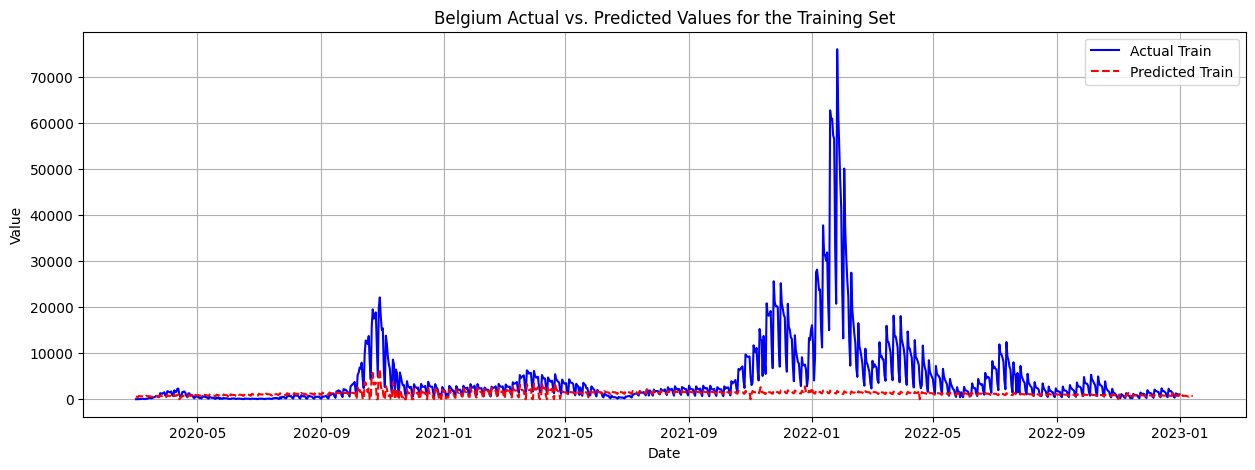

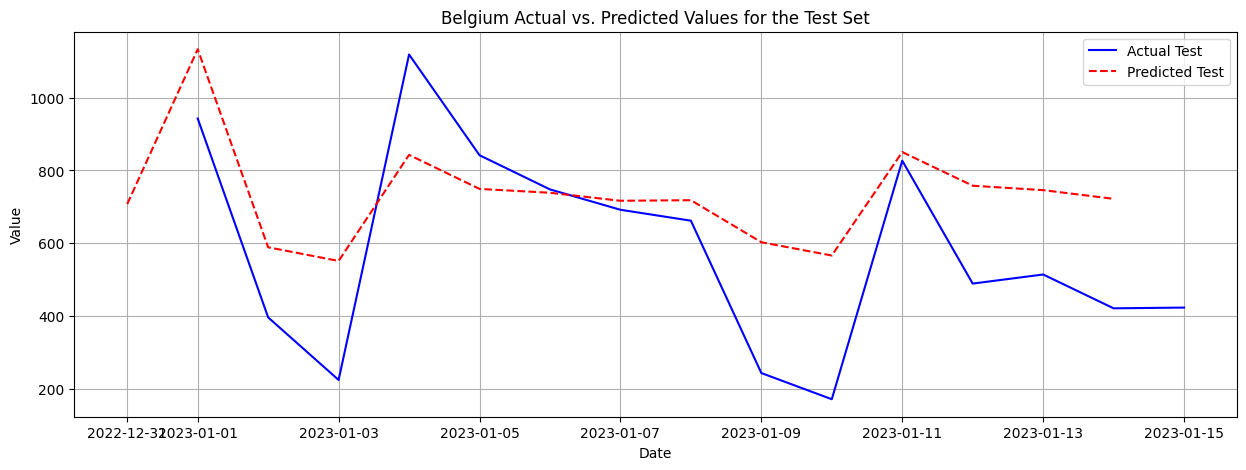

RMSE for the training set: 8238.199750728803
RMSE for the test set: 358.3012570839183
sRMSE for the training set: 182.1761291910428
sRMSE for the test set: 61.67682873833802


In [103]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays = belgium_lockdowns,**belgium_params, holidays_prior_scale = 2)
m.add_regressor('new_deaths')
m.add_regressor('reproduction_rate')
m.add_regressor('stringency_index')
m.add_regressor('new_cases_lag1')
m.add_regressor('new_cases_lag8')
m.add_regressor('new_cases_roll_mean7')
m.add_regressor('new_cases_roll_std7')
m.add_regressor('new_cases_roll_mean14')
m.add_regressor('new_cases_roll_std14')
m.add_country_holidays(country_name='Belgium')
m.fit(train_belgium)

# setting future dates
future = m.make_future_dataframe(periods=14)

future['new_deaths'] = train_belgium['new_deaths'].values[-1]  # Add a default value for the new regressors
future['reproduction_rate'] = train_belgium['reproduction_rate'].values[-1]
future['stringency_index'] = train_belgium['stringency_index'].values[-1]
future['new_cases_lag1'] = train_belgium['new_cases_lag1'].values[-1]
future['new_cases_lag8'] = train_belgium['new_cases_lag8'].values[-1]
future['new_cases_roll_mean7'] = train_belgium['new_cases_roll_mean7'].values[-1]
future['new_cases_roll_std7'] = train_belgium['new_cases_roll_std7'].values[-1]
future['new_cases_roll_mean14'] = train_belgium['new_cases_roll_mean14'].values[-1]
future['new_cases_roll_std14'] = train_belgium['new_cases_roll_std14'].values[-1]

# Python predict
forecast = m.predict(future)
# Set a minimum value for the predictions
min_value = 0
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, min_value))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_belgium['ds'] = pd.to_datetime(train_belgium['ds'])
test_belgium['ds'] = pd.to_datetime(test_belgium['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_belgium['ds'], train_belgium['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Belgium Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_belgium['ds'], test_belgium['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_belgium)), forecast['yhat'].tail(len(test_belgium)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Belgium Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_belgium['y'].values
predicted_train_values = forecast['yhat'].head(len(train_belgium)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_belgium['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_belgium)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)





### 2. Denmark

01:44:47 - cmdstanpy - INFO - Chain [1] start processing
01:44:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/1519467835.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_denmark['ds'] = pd.to_datetime(train_denmark['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/1519467835.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_denmark['ds'] = pd.to_datetime(test_denmark['ds'])


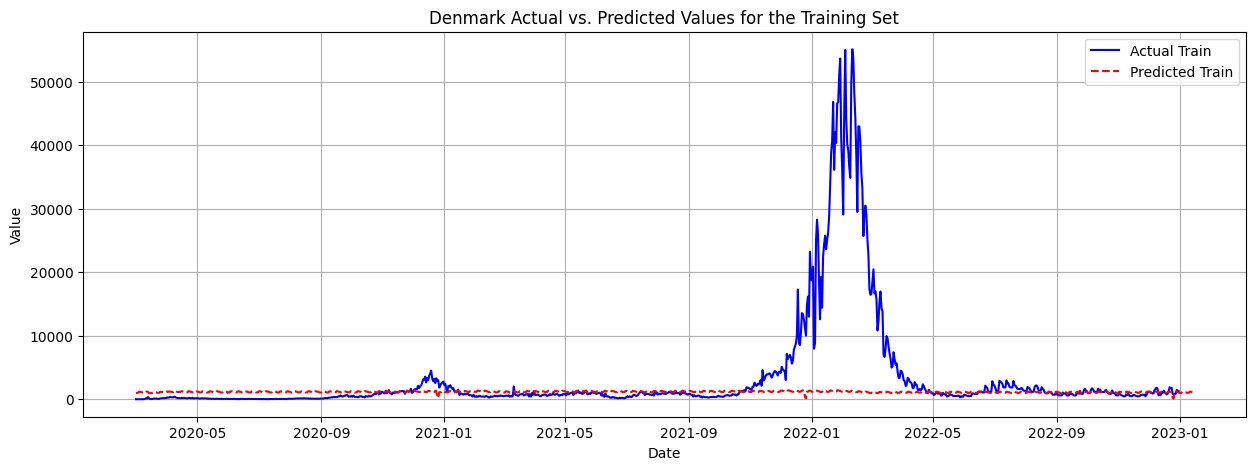

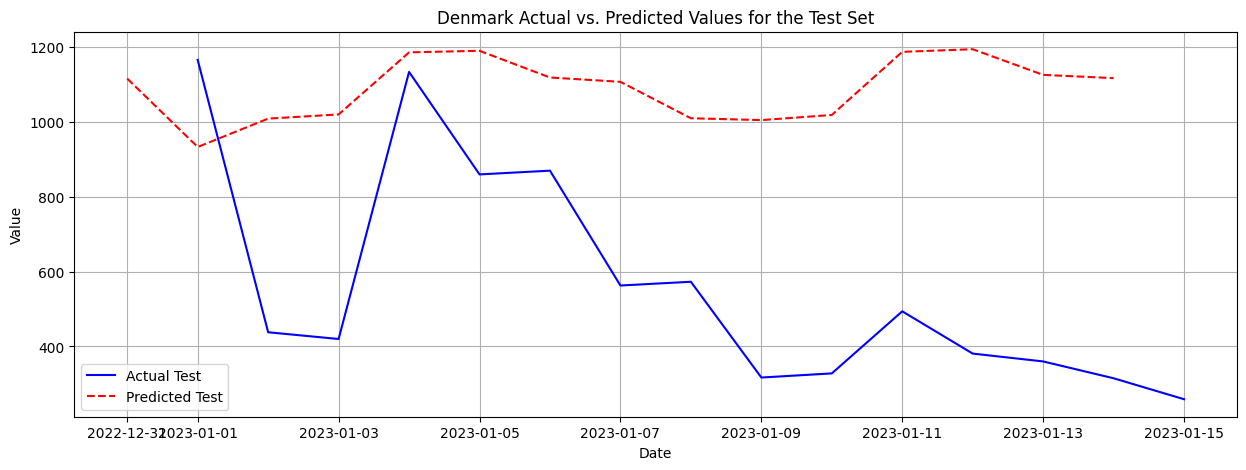

RMSE for the training set: 8559.908831801737
RMSE for the test set: 598.2392247593743
sRMSE for the training set: 261.7154438046852
sRMSE for the test set: 105.84558116761752


In [104]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=denmark_lockdowns, **denmark_params, holidays_prior_scale = 2)
m.add_regressor('new_deaths')
m.add_regressor('reproduction_rate')
m.add_regressor('stringency_index')
m.add_regressor('new_cases_lag1')
m.add_regressor('new_cases_lag8')
m.add_regressor('new_cases_roll_mean7')
m.add_regressor('new_cases_roll_std7')
m.add_regressor('new_cases_roll_mean14')
m.add_regressor('new_cases_roll_std14')
m.add_country_holidays(country_name='Denmark')
m.fit(train_denmark)

# setting future dates
future = m.make_future_dataframe(periods=14)

future['new_deaths'] = train_denmark['new_deaths'].values[-1]  # Add a default value for the new regressors
future['reproduction_rate'] = train_denmark['reproduction_rate'].values[-1]
future['stringency_index'] = train_denmark['stringency_index'].values[-1]
future['new_cases_lag1'] = train_denmark['new_cases_lag1'].values[-1]
future['new_cases_lag8'] = train_denmark['new_cases_lag8'].values[-1]
future['new_cases_roll_mean7'] = train_denmark['new_cases_roll_mean7'].values[-1]
future['new_cases_roll_std7'] = train_denmark['new_cases_roll_std7'].values[-1]
future['new_cases_roll_mean14'] = train_denmark['new_cases_roll_mean14'].values[-1]
future['new_cases_roll_std14'] = train_denmark['new_cases_roll_std14'].values[-1]


# Python predict
forecast = m.predict(future)
# Set a minimum value for the predictions
min_value = 0
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, min_value))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_denmark['ds'] = pd.to_datetime(train_denmark['ds'])
test_denmark['ds'] = pd.to_datetime(test_denmark['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_denmark['ds'], train_denmark['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Denmark Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_denmark['ds'], test_denmark['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_denmark)), forecast['yhat'].tail(len(test_denmark)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Denmark Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_denmark['y'].values
predicted_train_values = forecast['yhat'].head(len(train_denmark)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_denmark['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_denmark)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


### 3. Finland

01:44:48 - cmdstanpy - INFO - Chain [1] start processing
01:44:49 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/1240622741.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_finland['ds'] = pd.to_datetime(train_finland['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/1240622741.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_finland['ds'] = pd.to_datetime(test_finland['ds'])


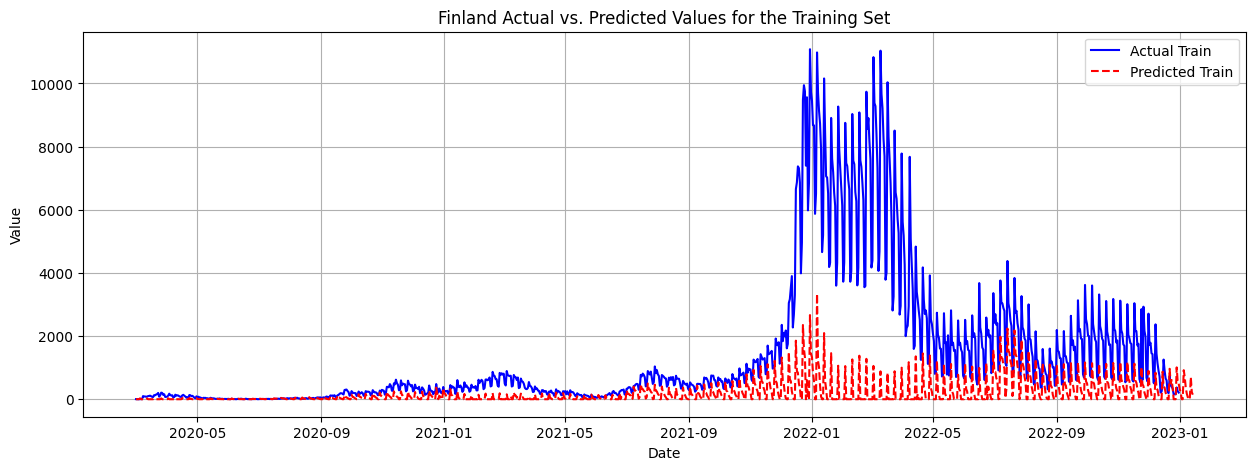

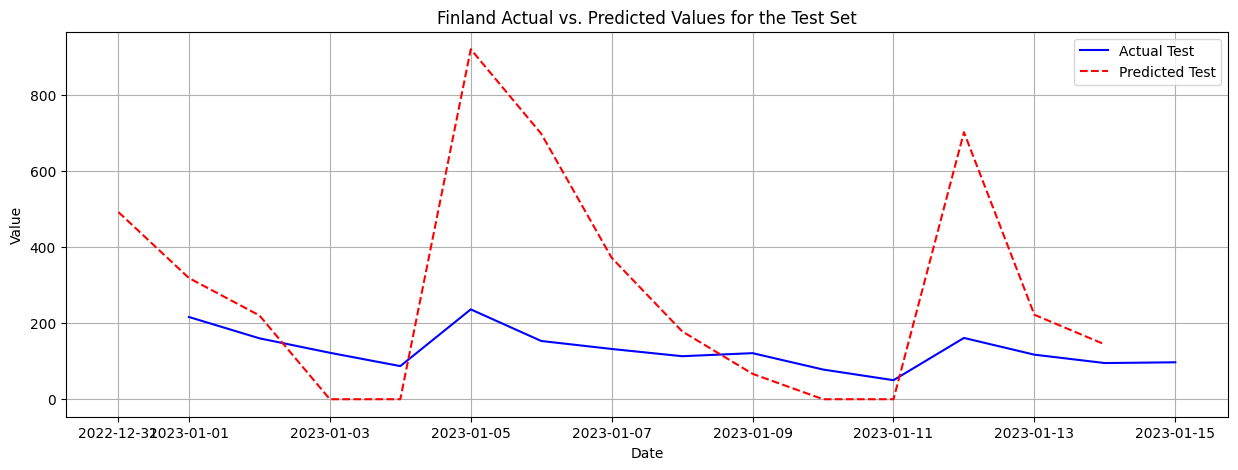

RMSE for the training set: 2381.5686790796417
RMSE for the test set: 320.3316234977262
sRMSE for the training set: 169.27152621404943
sRMSE for the test set: 247.93469310969522


In [105]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=finland_lockdowns, **finland_params, holidays_prior_scale = 2)
m.add_regressor('new_deaths')
m.add_regressor('reproduction_rate')
m.add_regressor('stringency_index')
m.add_regressor('new_cases_lag1')
m.add_regressor('new_cases_lag8')
m.add_regressor('new_cases_roll_mean7')
m.add_regressor('new_cases_roll_std7')
m.add_regressor('new_cases_roll_mean14')
m.add_regressor('new_cases_roll_std14')
m.add_country_holidays(country_name='Finland')
m.fit(train_finland)

# setting future dates
future = m.make_future_dataframe(periods=14)

future['new_deaths'] = train_finland['new_deaths'].values[-1]  # Add a default value for the new regressors
future['reproduction_rate'] = train_finland['reproduction_rate'].values[-1]
future['stringency_index'] = train_finland['stringency_index'].values[-1]
future['new_cases_lag1'] = train_finland['new_cases_lag1'].values[-1]
future['new_cases_lag8'] = train_finland['new_cases_lag8'].values[-1]
future['new_cases_roll_mean7'] = train_finland['new_cases_roll_mean7'].values[-1]
future['new_cases_roll_std7'] = train_finland['new_cases_roll_std7'].values[-1]
future['new_cases_roll_mean14'] = train_finland['new_cases_roll_mean14'].values[-1]
future['new_cases_roll_std14'] = train_finland['new_cases_roll_std14'].values[-1]

# Python predict
forecast = m.predict(future)
# Set a minimum value for the predictions
min_value = 0
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, min_value))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_finland['ds'] = pd.to_datetime(train_finland['ds'])
test_finland['ds'] = pd.to_datetime(test_finland['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_finland['ds'], train_finland['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Finland Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_finland['ds'], test_finland['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_finland)), forecast['yhat'].tail(len(test_finland)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Finland Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_finland['y'].values
predicted_train_values = forecast['yhat'].head(len(train_finland)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_finland['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_finland)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


### 4. Ireland

01:44:49 - cmdstanpy - INFO - Chain [1] start processing
01:44:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/1289240609.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ireland['ds'] = pd.to_datetime(train_ireland['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/1289240609.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ireland['ds'] = pd.to_datetime(test_ireland['ds'])


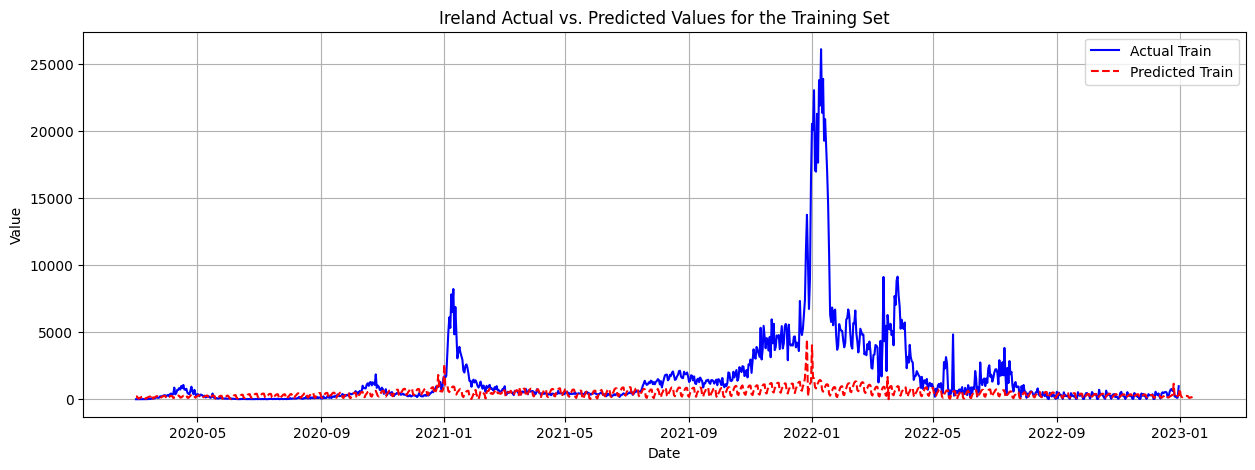

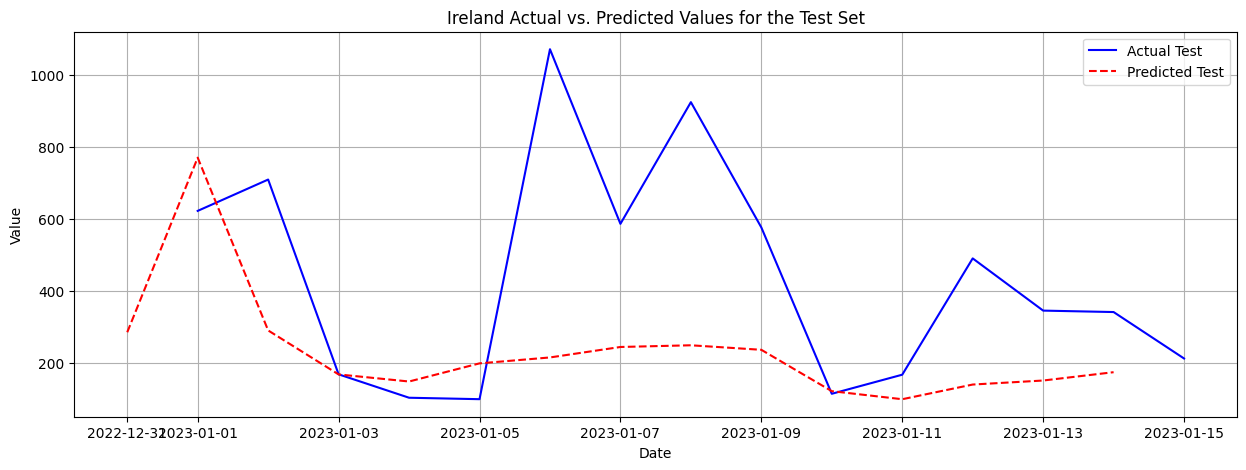

RMSE for the training set: 3093.1495398529046
RMSE for the test set: 351.87067937249935
sRMSE for the training set: 189.37508485010213
sRMSE for the test set: 80.86502513539897


In [106]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=ireland_lockdowns, **ireland_params, holidays_prior_scale = 2)
m.add_regressor('new_deaths')
m.add_regressor('reproduction_rate')
m.add_regressor('stringency_index')
m.add_regressor('new_cases_lag1')
m.add_regressor('new_cases_lag8')
m.add_regressor('new_cases_roll_mean7')
m.add_regressor('new_cases_roll_std7')
m.add_regressor('new_cases_roll_mean14')
m.add_regressor('new_cases_roll_std14')
m.add_country_holidays(country_name='Ireland')
m.fit(train_ireland)

# setting future dates
future = m.make_future_dataframe(periods=14)

future['new_deaths'] = train_ireland['new_deaths'].values[-1]  # Add a default value for the new regressors
future['reproduction_rate'] = train_ireland['reproduction_rate'].values[-1]
future['stringency_index'] = train_ireland['stringency_index'].values[-1]
future['new_cases_lag1'] = train_ireland['new_cases_lag1'].values[-1]
future['new_cases_lag8'] = train_ireland['new_cases_lag8'].values[-1]
future['new_cases_roll_mean7'] = train_ireland['new_cases_roll_mean7'].values[-1]
future['new_cases_roll_std7'] = train_ireland['new_cases_roll_std7'].values[-1]
future['new_cases_roll_mean14'] = train_ireland['new_cases_roll_mean14'].values[-1]
future['new_cases_roll_std14'] = train_ireland['new_cases_roll_std14'].values[-1]

# Python predict
forecast = m.predict(future)
# Set a minimum value for the predictions
min_value = 0
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, min_value))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_ireland['ds'] = pd.to_datetime(train_ireland['ds'])
test_ireland['ds'] = pd.to_datetime(test_ireland['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_ireland['ds'], train_ireland['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Ireland Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_ireland['ds'], test_ireland['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_ireland)), forecast['yhat'].tail(len(test_ireland)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Ireland Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_ireland['y'].values
predicted_train_values = forecast['yhat'].head(len(train_ireland)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_ireland['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_ireland)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


### 5. Italy

01:44:50 - cmdstanpy - INFO - Chain [1] start processing
01:44:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/3317844488.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_italy['ds'] = pd.to_datetime(train_italy['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/3317844488.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_italy['ds'] = pd.to_datetime(test_italy['ds'])


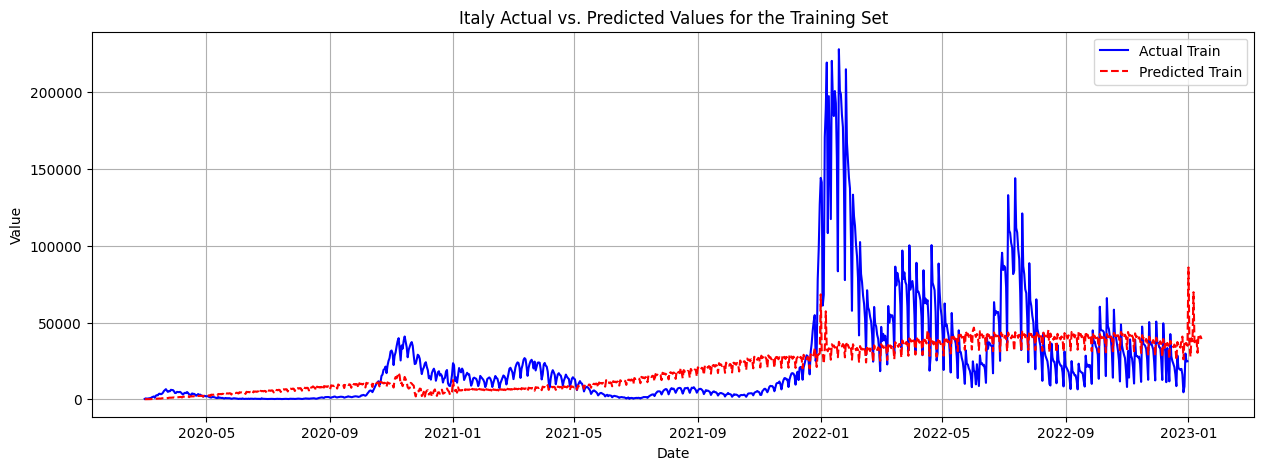

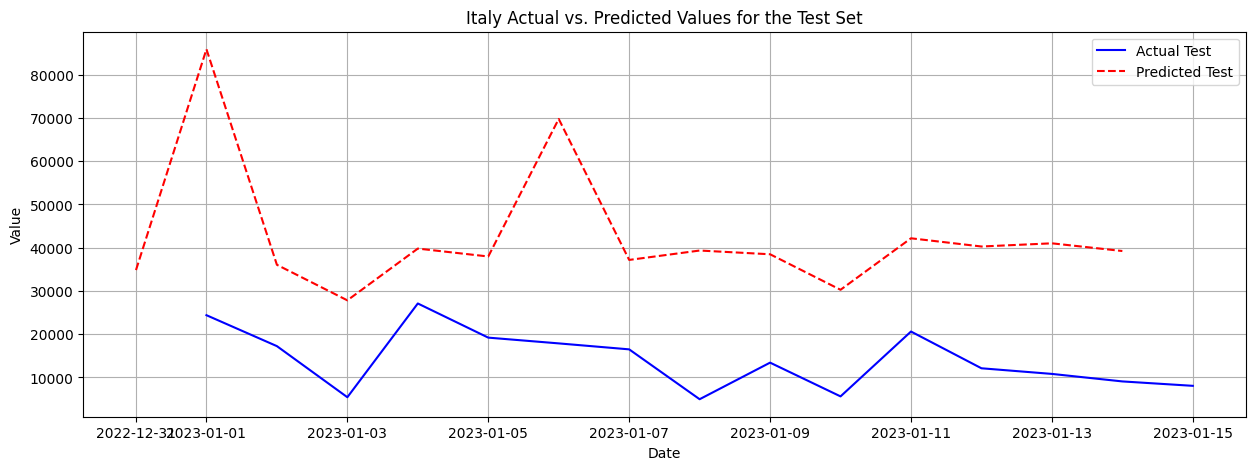

RMSE for the training set: 29241.4346654957
RMSE for the test set: 32726.56984268262
sRMSE for the training set: 120.36978694173071
sRMSE for the test set: 231.06544958354402


In [107]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=italy_lockdowns, **italy_params, holidays_prior_scale = 2)
m.add_regressor('new_deaths')
m.add_regressor('reproduction_rate')
m.add_regressor('stringency_index')
m.add_regressor('new_cases_lag1')
m.add_regressor('new_cases_lag8')
m.add_regressor('new_cases_roll_mean7')
m.add_regressor('new_cases_roll_std7')
m.add_regressor('new_cases_roll_mean14')
m.add_regressor('new_cases_roll_std14')
m.add_country_holidays(country_name='Italy')
m.fit(train_italy)

# setting future dates
future = m.make_future_dataframe(periods=14)

future['new_deaths'] = train_italy['new_deaths'].values[-1]  # Add a default value for the new regressors
future['reproduction_rate'] = train_italy['reproduction_rate'].values[-1]
future['stringency_index'] = train_italy['stringency_index'].values[-1]
future['new_cases_lag1'] = train_italy['new_cases_lag1'].values[-1]
future['new_cases_lag8'] = train_italy['new_cases_lag8'].values[-1]
future['new_cases_roll_mean7'] = train_italy['new_cases_roll_mean7'].values[-1]
future['new_cases_roll_std7'] = train_italy['new_cases_roll_std7'].values[-1]
future['new_cases_roll_mean14'] = train_italy['new_cases_roll_mean14'].values[-1]
future['new_cases_roll_std14'] = train_italy['new_cases_roll_std14'].values[-1]

# Python predict
forecast = m.predict(future)
# Set a minimum value for the predictions
min_value = 0
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, min_value))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_italy['ds'] = pd.to_datetime(train_italy['ds'])
test_italy['ds'] = pd.to_datetime(test_italy['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_italy['ds'], train_italy['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Italy Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_italy['ds'], test_italy['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_italy)), forecast['yhat'].tail(len(test_italy)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Italy Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_italy['y'].values
predicted_train_values = forecast['yhat'].head(len(train_italy)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_italy['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_italy)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


### 6. Lithuania

01:44:52 - cmdstanpy - INFO - Chain [1] start processing
01:44:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/3870355817.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_lithuania['ds'] = pd.to_datetime(train_lithuania['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/3870355817.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_lithuania['ds'] = pd.to_datetime(test_lithuania['ds'])


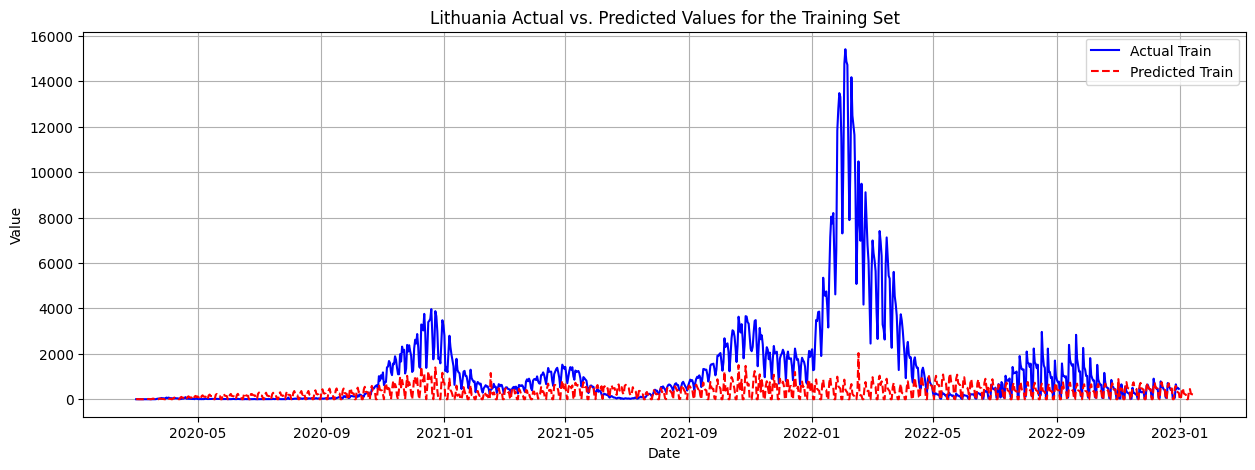

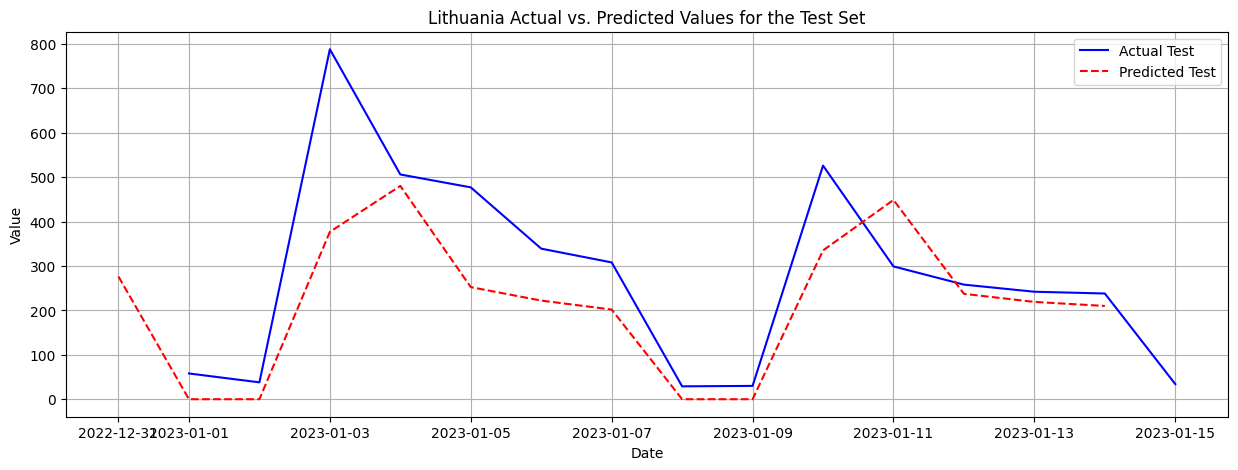

RMSE for the training set: 2224.1548427409793
RMSE for the test set: 268.0880972904792
sRMSE for the training set: 178.8408159034582
sRMSE for the test set: 96.43456737067598


In [108]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=lithuania_lockdowns, **lithuania_params, holidays_prior_scale = 2)
m.add_regressor('new_deaths')
m.add_regressor('reproduction_rate')
m.add_regressor('stringency_index')
m.add_regressor('new_cases_lag1')
m.add_regressor('new_cases_lag8')
m.add_regressor('new_cases_roll_mean7')
m.add_regressor('new_cases_roll_std7')
m.add_regressor('new_cases_roll_mean14')
m.add_regressor('new_cases_roll_std14')
m.add_country_holidays(country_name='Lithuania')
m.fit(train_lithuania)

# setting future dates
future = m.make_future_dataframe(periods=14)

future['new_deaths'] = train_lithuania['new_deaths'].values[-1]  # Add a default value for the new regressors
future['reproduction_rate'] = train_lithuania['reproduction_rate'].values[-1]
future['stringency_index'] = train_lithuania['stringency_index'].values[-1]
future['new_cases_lag1'] = train_lithuania['new_cases_lag1'].values[-1]
future['new_cases_lag8'] = train_lithuania['new_cases_lag8'].values[-1]
future['new_cases_roll_mean7'] = train_lithuania['new_cases_roll_mean7'].values[-1]
future['new_cases_roll_std7'] = train_lithuania['new_cases_roll_std7'].values[-1]
future['new_cases_roll_mean14'] = train_lithuania['new_cases_roll_mean14'].values[-1]
future['new_cases_roll_std14'] = train_lithuania['new_cases_roll_std14'].values[-1]

# Python predict
forecast = m.predict(future)
min_value = 0
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, min_value))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_lithuania['ds'] = pd.to_datetime(train_lithuania['ds'])
test_lithuania['ds'] = pd.to_datetime(test_lithuania['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_lithuania['ds'], train_lithuania['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Lithuania Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_lithuania['ds'], test_lithuania['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_lithuania)), forecast['yhat'].tail(len(test_lithuania)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Lithuania Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_lithuania['y'].values
predicted_train_values = forecast['yhat'].head(len(train_lithuania)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_lithuania['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_lithuania)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


### 7. Norway

01:44:53 - cmdstanpy - INFO - Chain [1] start processing
01:44:54 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/1183786913.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_norway['ds'] = pd.to_datetime(train_norway['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/1183786913.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_norway['ds'] = pd.to_datetime(test_norway['ds'])


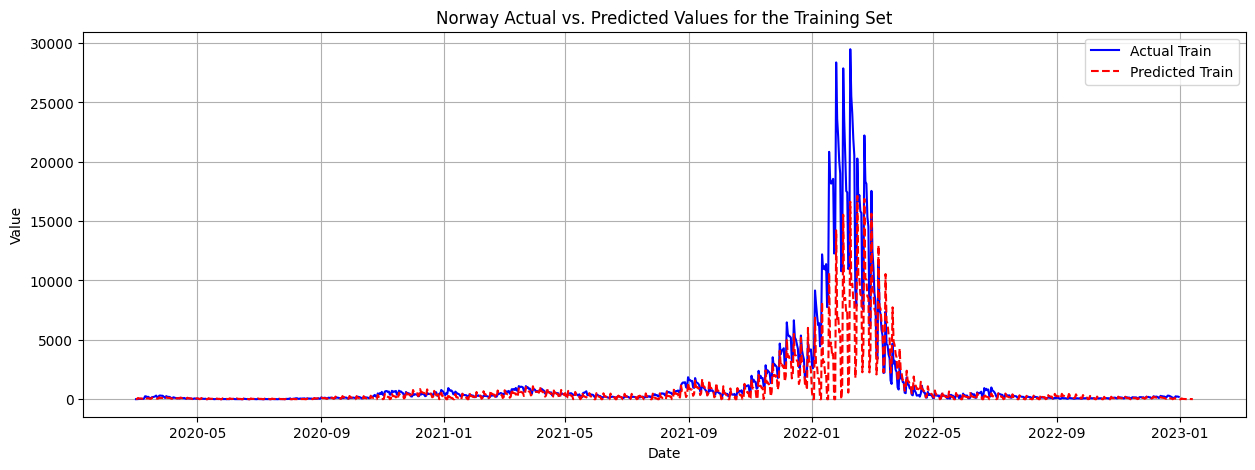

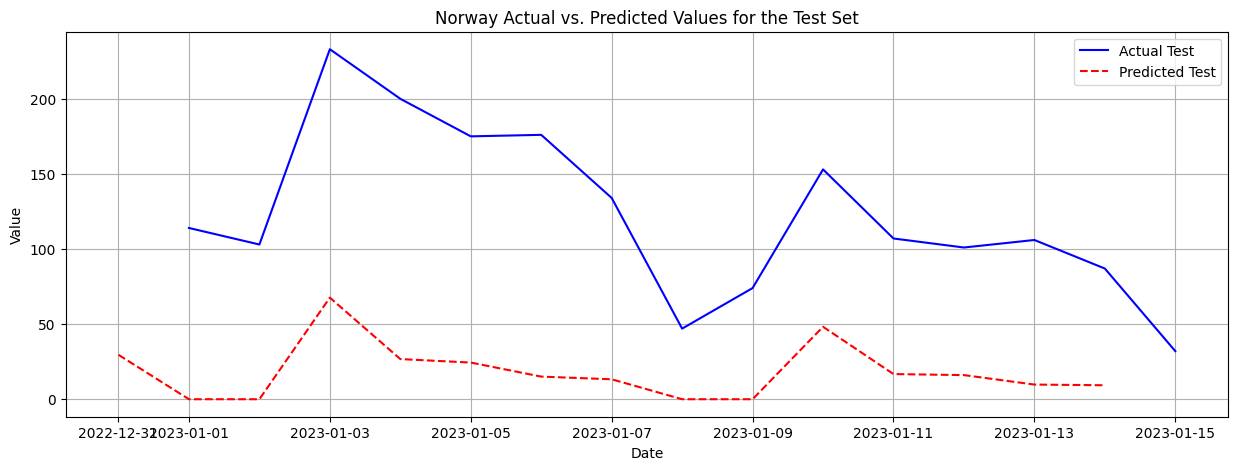

RMSE for the training set: 2362.010901988023
RMSE for the test set: 116.56236274408626
sRMSE for the training set: 165.8274892291694
sRMSE for the test set: 94.92049083394647


In [109]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=norway_lockdowns, **norway_params, holidays_prior_scale = 2)
m.add_regressor('new_deaths')
m.add_regressor('reproduction_rate')
m.add_regressor('stringency_index')
m.add_regressor('new_cases_lag1')
m.add_regressor('new_cases_lag8')
m.add_regressor('new_cases_roll_mean7')
m.add_regressor('new_cases_roll_std7')
m.add_regressor('new_cases_roll_mean14')
m.add_regressor('new_cases_roll_std14')
m.add_country_holidays(country_name='Norway')
m.fit(train_norway)

# setting future dates
future = m.make_future_dataframe(periods=14)

future['new_deaths'] = train_norway['new_deaths'].values[-1]  # Add a default value for the new regressors
future['reproduction_rate'] = train_norway['reproduction_rate'].values[-1]
future['stringency_index'] = train_norway['stringency_index'].values[-1]
future['new_cases_lag1'] = train_norway['new_cases_lag1'].values[-1]
future['new_cases_lag8'] = train_norway['new_cases_lag8'].values[-1]
future['new_cases_roll_mean7'] = train_norway['new_cases_roll_mean7'].values[-1]
future['new_cases_roll_std7'] = train_norway['new_cases_roll_std7'].values[-1]
future['new_cases_roll_mean14'] = train_norway['new_cases_roll_mean14'].values[-1]
future['new_cases_roll_std14'] = train_norway['new_cases_roll_std14'].values[-1]

# Python predict
forecast = m.predict(future)
min_value = 0
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, min_value))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_norway['ds'] = pd.to_datetime(train_norway['ds'])
test_norway['ds'] = pd.to_datetime(test_norway['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_norway['ds'], train_norway['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Norway Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_norway['ds'], test_norway['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_norway)), forecast['yhat'].tail(len(test_norway)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Norway Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_norway['y'].values
predicted_train_values = forecast['yhat'].head(len(train_norway)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_norway['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_norway)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


### 8. Poland

01:44:55 - cmdstanpy - INFO - Chain [1] start processing
01:44:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/2532973526.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_poland['ds'] = pd.to_datetime(train_poland['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/2532973526.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_poland['ds'] = pd.to_datetime(test_poland['ds'])


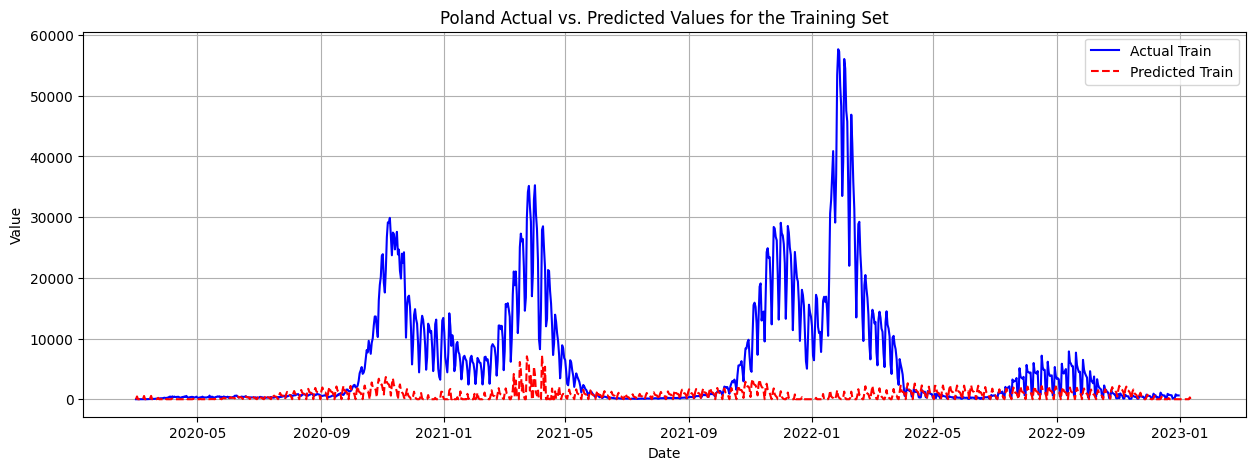

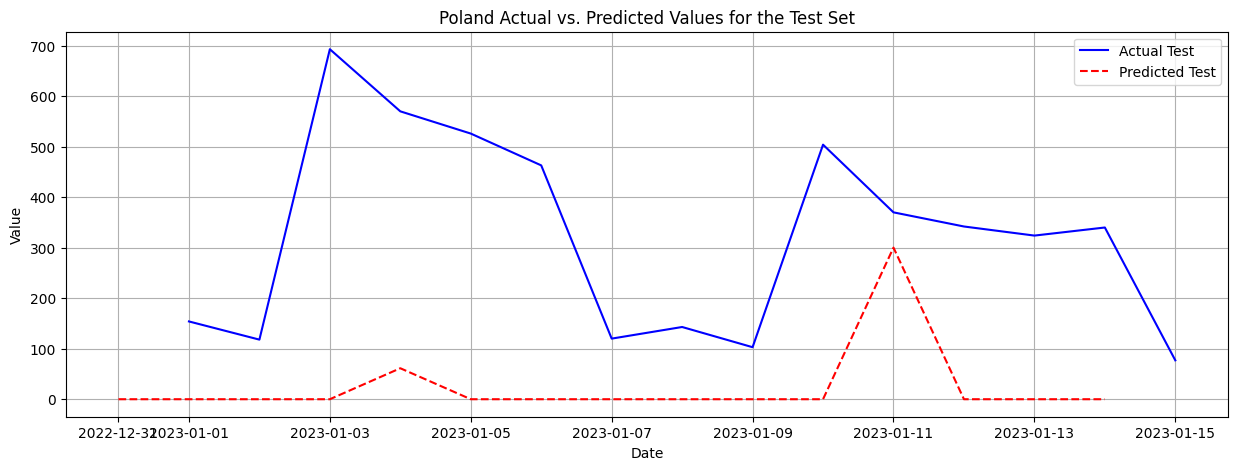

RMSE for the training set: 10681.238405902286
RMSE for the test set: 359.41624379887276
sRMSE for the training set: 173.76081652868464
sRMSE for the test set: 111.22846414241987


In [110]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=poland_lockdowns, **poland_params, holidays_prior_scale = 2)
m.add_regressor('new_deaths')
m.add_regressor('reproduction_rate')
m.add_regressor('stringency_index')
m.add_regressor('new_cases_lag1')
m.add_regressor('new_cases_lag8')
m.add_regressor('new_cases_roll_mean7')
m.add_regressor('new_cases_roll_std7')
m.add_regressor('new_cases_roll_mean14')
m.add_regressor('new_cases_roll_std14')
m.add_country_holidays(country_name='Poland')
m.fit(train_poland)

# setting future dates
future = m.make_future_dataframe(periods=14)

future['new_deaths'] = train_poland['new_deaths'].values[-1]  # Add a default value for the new regressors
future['reproduction_rate'] = train_poland['reproduction_rate'].values[-1]
future['stringency_index'] = train_poland['stringency_index'].values[-1]
future['new_cases_lag1'] = train_poland['new_cases_lag1'].values[-1]
future['new_cases_lag8'] = train_poland['new_cases_lag8'].values[-1]
future['new_cases_roll_mean7'] = train_poland['new_cases_roll_mean7'].values[-1]
future['new_cases_roll_std7'] = train_poland['new_cases_roll_std7'].values[-1]
future['new_cases_roll_mean14'] = train_poland['new_cases_roll_mean14'].values[-1]
future['new_cases_roll_std14'] = train_poland['new_cases_roll_std14'].values[-1]

# Python predict
forecast = m.predict(future)
min_value = 0
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, min_value))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_poland['ds'] = pd.to_datetime(train_poland['ds'])
test_poland['ds'] = pd.to_datetime(test_poland['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_poland['ds'], train_poland['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Poland Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_poland['ds'], test_poland['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_poland)), forecast['yhat'].tail(len(test_poland)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Poland Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_poland['y'].values
predicted_train_values = forecast['yhat'].head(len(train_poland)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_poland['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_poland)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


### 9. Switzerland

01:44:57 - cmdstanpy - INFO - Chain [1] start processing
01:45:01 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/1185823141.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_switzerland['ds'] = pd.to_datetime(train_switzerland['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/1185823141.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_switzerland['ds'] = pd.to_datetime(test_switzerland['ds'])


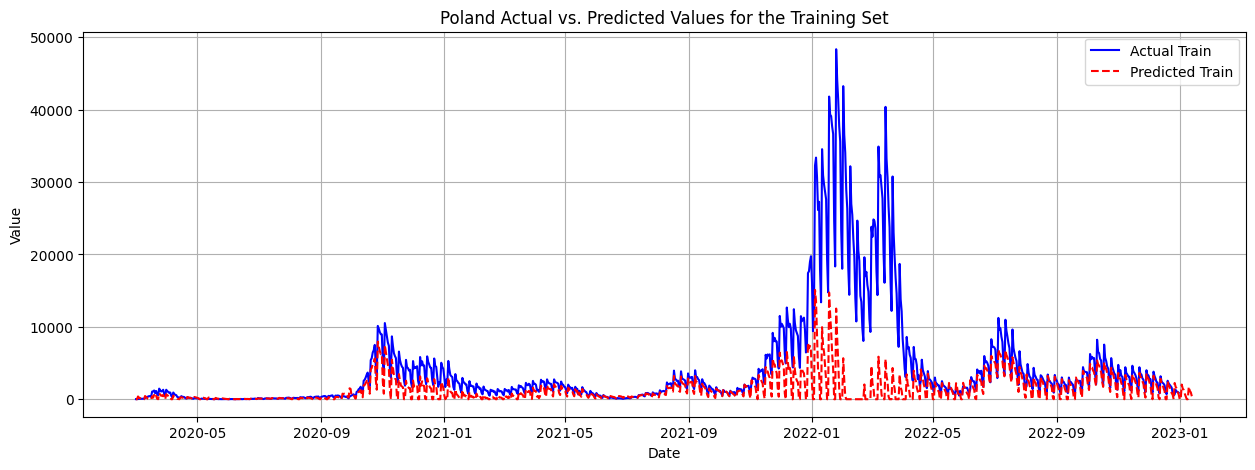

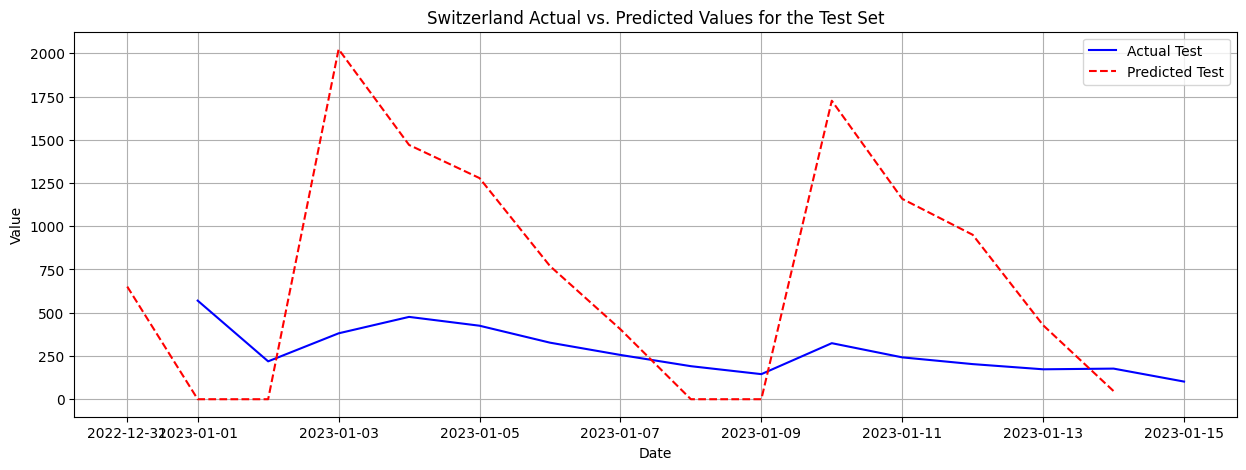

RMSE for the training set: 6956.123989802876
RMSE for the test set: 766.5149672416313
sRMSE for the training set: 164.51678963635726
sRMSE for the test set: 273.0402400528252


In [111]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=swiss_lockdowns, **swiss_params, holidays_prior_scale = 2)
m.add_regressor('new_deaths')
m.add_regressor('reproduction_rate')
m.add_regressor('stringency_index')
m.add_regressor('new_cases_lag1')
m.add_regressor('new_cases_lag8')
m.add_regressor('new_cases_roll_mean7')
m.add_regressor('new_cases_roll_std7')
m.add_regressor('new_cases_roll_mean14')
m.add_regressor('new_cases_roll_std14')
m.add_country_holidays(country_name='Switzerland')
m.fit(train_switzerland)

# setting future dates
future = m.make_future_dataframe(periods=14)

future['new_deaths'] = train_switzerland['new_deaths'].values[-1]  # Add a default value for the new regressors
future['reproduction_rate'] = train_switzerland['reproduction_rate'].values[-1]
future['stringency_index'] = train_switzerland['stringency_index'].values[-1]
future['new_cases_lag1'] = train_switzerland['new_cases_lag1'].values[-1]
future['new_cases_lag8'] = train_switzerland['new_cases_lag8'].values[-1]
future['new_cases_roll_mean7'] = train_switzerland['new_cases_roll_mean7'].values[-1]
future['new_cases_roll_std7'] = train_switzerland['new_cases_roll_std7'].values[-1]
future['new_cases_roll_mean14'] = train_switzerland['new_cases_roll_mean14'].values[-1]
future['new_cases_roll_std14'] = train_switzerland['new_cases_roll_std14'].values[-1]

# Python predict
forecast = m.predict(future)
min_value = 0
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, min_value))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_switzerland['ds'] = pd.to_datetime(train_switzerland['ds'])
test_switzerland['ds'] = pd.to_datetime(test_switzerland['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_switzerland['ds'], train_switzerland['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Poland Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_switzerland['ds'], test_switzerland['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_switzerland)), forecast['yhat'].tail(len(test_switzerland)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Switzerland Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_switzerland['y'].values
predicted_train_values = forecast['yhat'].head(len(train_switzerland)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_switzerland['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_switzerland)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


### 10. United Kingdom

01:45:02 - cmdstanpy - INFO - Chain [1] start processing
01:45:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/4090513770.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_uk['ds'] = pd.to_datetime(train_uk['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_16356/4090513770.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_uk['ds'] = pd.to_datetime(test_uk['ds'])


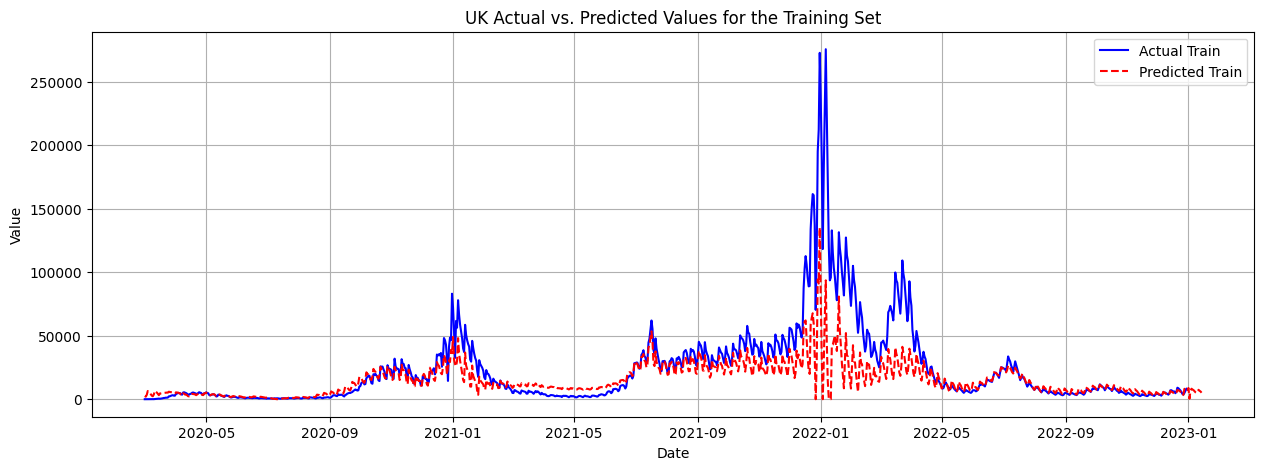

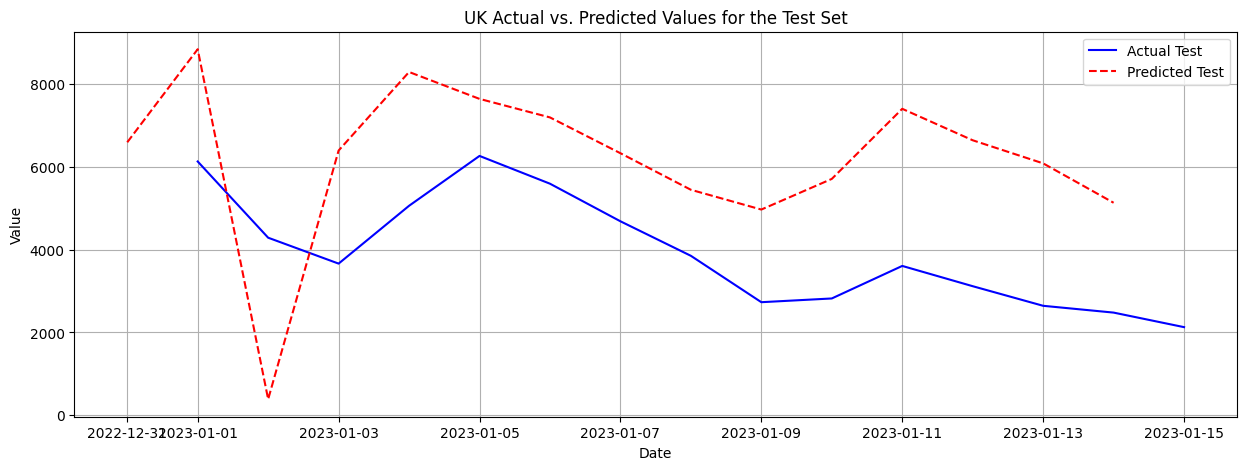

RMSE for the training set: 24109.972689114056
RMSE for the test set: 2906.030928223758
sRMSE for the training set: 103.23812956004129
sRMSE for the test set: 73.8283351512565


In [112]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=uk_lockdowns, **uk_params, holidays_prior_scale = 2)
m.add_regressor('new_deaths')
m.add_regressor('reproduction_rate')
m.add_regressor('stringency_index')
m.add_regressor('new_cases_lag1')
m.add_regressor('new_cases_lag8')
m.add_regressor('new_cases_roll_mean7')
m.add_regressor('new_cases_roll_std7')
m.add_regressor('new_cases_roll_mean14')
m.add_regressor('new_cases_roll_std14')
m.add_country_holidays(country_name='GB')
m.fit(train_uk)

# setting future dates
future = m.make_future_dataframe(periods=14)

future['new_deaths'] = train_uk['new_deaths'].values[-1]  # Add a default value for the new regressors
future['reproduction_rate'] = train_uk['reproduction_rate'].values[-1]
future['stringency_index'] = train_uk['stringency_index'].values[-1]
future['new_cases_lag1'] = train_uk['new_cases_lag1'].values[-1]
future['new_cases_lag8'] = train_uk['new_cases_lag8'].values[-1]
future['new_cases_roll_mean7'] = train_uk['new_cases_roll_mean7'].values[-1]
future['new_cases_roll_std7'] = train_uk['new_cases_roll_std7'].values[-1]
future['new_cases_roll_mean14'] = train_uk['new_cases_roll_mean14'].values[-1]
future['new_cases_roll_std14'] = train_uk['new_cases_roll_std14'].values[-1]


# Python predict
forecast = m.predict(future)
min_value = 0
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, min_value))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_uk['ds'] = pd.to_datetime(train_uk['ds'])
test_uk['ds'] = pd.to_datetime(test_uk['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_uk['ds'], train_uk['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('UK Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_uk['ds'], test_uk['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_uk)), forecast['yhat'].tail(len(test_uk)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('UK Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_uk['y'].values
predicted_train_values = forecast['yhat'].head(len(train_uk)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_uk['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_uk)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


In [115]:
# Results
results_table = pd.DataFrame({
    'Location': country_names,
    'Train RMSE': final_train_rmse,
    'Test RMSE': final_test_rmse,
    'Standardized RMSE': standardized_rmse,
})
results_table

,Location,Train RMSE,Test RMSE,Standardized RMSE
0,Belgium,8238.199751,358.301257,61.676829
1,Denmark,8559.908832,598.239225,105.845581
2,Finland,2381.568679,320.331623,247.934693
3,Ireland,3093.149540,351.870679,80.865025
4,Italy,29241.434665,32726.569843,231.065450
5,Lithuania,2224.154843,268.088097,96.434567
6,Norway,2362.010902,116.562363,94.920491
7,Poland,10681.238406,359.416244,111.228464
8,Switzerland,6956.123990,766.514967,273.040240
9,United Kingdom,24109.972689,2906.030928,73.828335
